# Ejemplo de resolución del problema de Poisson con distintas condiciones de contorno y manipulación de la solución para el problema de cálculo de capacitancias #


El problema a resolver es:


\begin{align}
-\Delta u &= f \;\;\;\;\; \text{in } \Omega \\
u &= g \;\;\;\;\; \text{in } \partial \Omega_{int} \\
\hat{n} \cdot \nabla u &= h \;\;\;\;\; \text{in } \partial \Omega_{ext} \\
\end{align}

Para ello impondremos la versión débil del mismo:

Encuentre $u$ en $H^1(\Omega, f))$ (o sea con las condiciones de contorno de Dirichlet en $\partial \Omega_{int}$) tal que,

$$
\int_{\Omega} \nabla v \cdot \nabla u \; d\Omega 
- \int_{\Omega} v \; f \; d\Omega 
- \oint_{\partial \Omega_{ext}} v \; h \; d\Gamma 
= 0 \;\;\;\;\; \forall v \;\; \in H^1_0(\Omega)
$$

Si obtenemos un $u$ satisfaciendo esta ecuación, y es suficientemente suave, entonces podemos integrar por partes el primer término y obtener:

$$
\int_{\Omega}  v \; (-\Delta u - f) \; d\Omega 
+ \oint_{\partial \Omega_{ext}} v \; (\hat{n} \cdot \nabla u - h) \; d\Gamma 
= 0 \;\;\;\;\; \forall v \;\; \in H^1_0(\Omega)
$$

Tomando $v$ arbitrario pero de soporte compacto vemos que $u$ debe satisfacer:

$$
-\Delta u = f \;\;\;\;\; \text{in } \Omega,
$$
y tomando $v$ arbitrario vemos que también se debe cumplir la condición de Neumann,

$$
\hat{n} \cdot \nabla u = h \;\;\;\;\; \text{in } \partial \Omega_{ext}.
$$

La condición de Dirichlet es automática por la elección del espacio.

Luego utilizaremos la solución encontrada para un problema de capacitancia.




Para resolver el problema utilizaremos la infraestructura del paquete `Gridap.jl` de Julia. Este ejemplo es una recopilación de varios ejemplos en el tutorial del paquete. 

In [1]:
#import Pkg; Pkg.activate("gridap_makie")
using Gridap
using FileIO #Gráficos y salidas
#mkdir("models")
#mkdir("images")
using GridapGmsh
#using gmsh #]add https://github.com/koehlerson/gmsh.jl.git
using Gmsh

In [1]:
#plot_s = false #true
plot_s = true
if plot_s
    #using Pkg; Pkg.activate("./gridap_makie")
    #Pkg.add(Pkg.PackageSpec(;name="Makie", version="0.12"))
    using Makie
    using GridapMakie, GLMakie #Para graficar 
end

Vamos a usar grillas construidas con la librería `gmsh`, a través del script ```mesh_generator.jl```. Notar que en el script se da nombre a las tres fronteras, la externa (rectangular), `"ext"` y las internas `"inner_circle"` y `"inner_square"`. En base al script, y siguiendo el tutorial de `gmsh`, podrán construir otras grillas. También se pueden usar otras librerías para construir grillas. Estas se importan a la infraestructura **Gridap** y con ellas se construye la triangulación a usar. 

In [3]:
include("mesh_generator.jl")

make_model (generic function with 1 method)

In [4]:
grid_type = "rectangle_hole_square"

#Resoluciones:
res = 1

if res == 1
    lc = 1e-1
    lc_f = 0.25e-1
    name = grid_type * "_coarse"
elseif res == 2 
    lc = 5e-2
    lc_f = 2.5e-2
    name = grid_type * "_intermediate"
elseif res == 3
    lc = 1e-2
    lc_f = 0.25e-2
    name = grid_type * "_finner"
end
    
#Lados exteriores de la grilla rectangular
side_x = 2
side_y = 1

#Rectangulo interior
rec_base = 0.25  #Coordenada y de la base
rec_top = 0.75   #Coordenada y del lado superior
rec_left = 1.25  #Coordenada x del lado izquierdo
rec_right = 1.75 #Coordenada x del lado derecho

#Circulo interior
circ_center_x = 0.5  #Coordenada x del centro
circ_center_y = 0.5  #Coordenada y del centro
circ_radius = 0.25   #Radio



p = (name, side_x, side_y, circ_center_x, circ_center_y, circ_radius, rec_base, rec_top, rec_left, rec_right, lc, lc_f)

("rectangle_hole_square_coarse", 2, 1, 0.5, 0.5, 0.25, 0.25, 0.75, 1.25, 1.75, 0.1, 0.025)

In [5]:
model = make_model(grid_type, p)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Circle)
Info    : [ 50%] Meshing curve 6 (Circle)
Info    : [ 50%] Meshing curve 7 (Circle)
Info    : [ 60%] Meshing curve 8 (Circle)
Info    : [ 70%] Meshing curve 10 (Line)
Info    : [ 80%] Meshing curve 11 (Line)
Info    : [ 90%] Meshing curve 12 (Line)
Info    : [100%] Meshing curve 13 (Line)
Info    : Done meshing 1D (Wall 0.00360014s, CPU 0.001088s)
Info    : Meshing 2D...
Info    : Meshing surface 1000 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0416033s, CPU 0.029269s)
Info    : 967 nodes 1947 elements
Info    : Writing 'models/rectangle_hole_square_coarse.msh'...
Info    : Done writing 'models/rectangle_hole_square_coarse.msh'
Info    : Reading 'models/rectangle_hole_square_coarse.msh'...
Info    : 26 entities
Info    : 966 nodes
Info    : 1934 el

UnstructuredDiscreteModel()

In [6]:
Ω = Triangulation(model)

BodyFittedTriangulation()

In [7]:
degree = 3
dΩ = Measure(Ω,degree)

Measure()

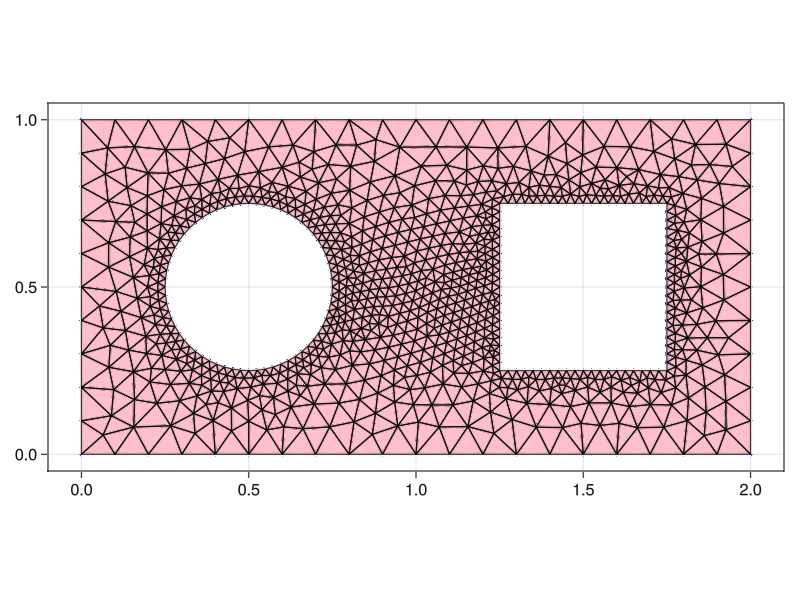

In [8]:
if plot_s
    fig, ax = plot(Ω)
    ax.aspect = AxisAspect(2)
    wireframe!(Ω, color=:black, linewidth=1)
    scatter!(Ω, marker=:star8, markersize=4, color=:blue)
    fig
end

También podemos graficar los contornos:

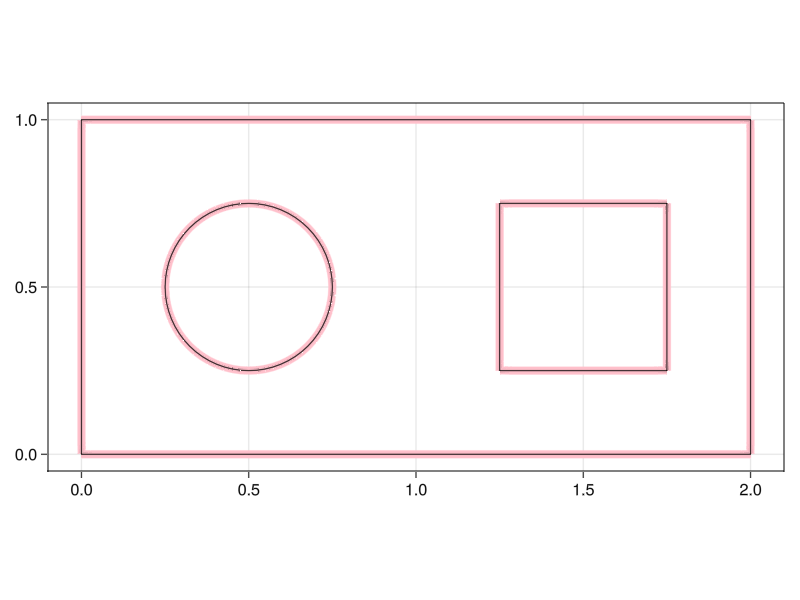

In [9]:
boundary_tags = ["inner_circle", "inner_square", "ext"]

Γ = BoundaryTriangulation(model,tags=boundary_tags)
dΓ = Measure(Γ,degree)

if plot_s
    fig, ax = plot(Γ, linewidth=8)
    ax.aspect = AxisAspect(2)
    wireframe!(Γ, color=:black, linewidth=1)
    fig
end

Vamos a elegir dos problemas simples para calcular la matríz de capacitancia de un conjunto de conductores. Tomaremos a los conductores como los dos cuerpos: el círculo y el cuadrado y pondremos condiciones de potencial constante. El borde externo se tomará como *infinito* y pondremos allí siempre potencial cero.

In [10]:
capacity_cs = false # potencial 1 en el círculo y potencial 0 en el cuadrado.
capacity_sc = false # potencial 0 en el círculo y potencial 1 en el cuadrado.
capacity_cs = true
#capacity_sc = true 

true

Una vez que tenemos el grillado comenzamos a definir los elementos finitos que utilizaremos. En este caso usaremos elementos lagrangiano de **orden 1** que cumplirán una condición de Dirichlet en la región $\partial \Omega_{int}$. Al construirse la grilla esta región ha sido marcada como la frontera interior del rectángulo con el `tag` `"int"`. 

In [11]:
order = 1
reffe = ReferenceFE(lagrangian,Float64,order)

dirichlet_tags= ["inner_circle", "inner_square","ext"] 

V = TestFESpace(model,reffe;conformity=:H1,dirichlet_tags = dirichlet_tags)
#V = TestFESpace(model,reffe;conformity=:L2,dirichlet_tags = dirichlet_tags) #no funciona la inversión. 

UnconstrainedFESpace()

Asignamos los valores de contorno para los potenciales. 

In [12]:
# internal Dirichlet boundary condition
g(x) = 1.0 # esta puede ser una función de x (vector posición)
if capacity_cs
    U = TrialFESpace(V,[g 0.0 0.0])
elseif capacity_sc
    U = TrialFESpace(V,[0.0 g 0.0])
end

TrialFESpace()

A continuación definimos el problema débil en forma abstracta:

In [13]:
f(x) = 0 # en este caso la fuente es cero, pero se puede poner una distribución de carga.

a(u,v) = ∫( ∇(v)⋅∇(u) )*dΩ  # en a(u,v) va toda la dependencia con u que es la incógnita. 

b(v) = ∫(v*f )*dΩ # aquí todo lo que es fuente. 


b (generic function with 1 method)

A partir de este punto el paquete **Gridap.jl** genera un sistema del tipo $Ax=b$ y lo resuelve para la versión elementos finitos de u.

In [14]:
op = AffineFEOperator(a,b,U,V)

AffineFEOperator()

In [15]:
ls = LUSolver()
lb = BackslashSolver() # x = A \ b
solver = LinearFESolver(lb)

LinearFESolver()

In [16]:
uh = solve(solver,op)
#uh = solve(op)

SingleFieldFEFunction():
 num_cells: 1730
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 4442125415518011880

Ahora podemos graficar la solución encontrada y guardarla además en un archivo que se puede leer con paraview o visit.

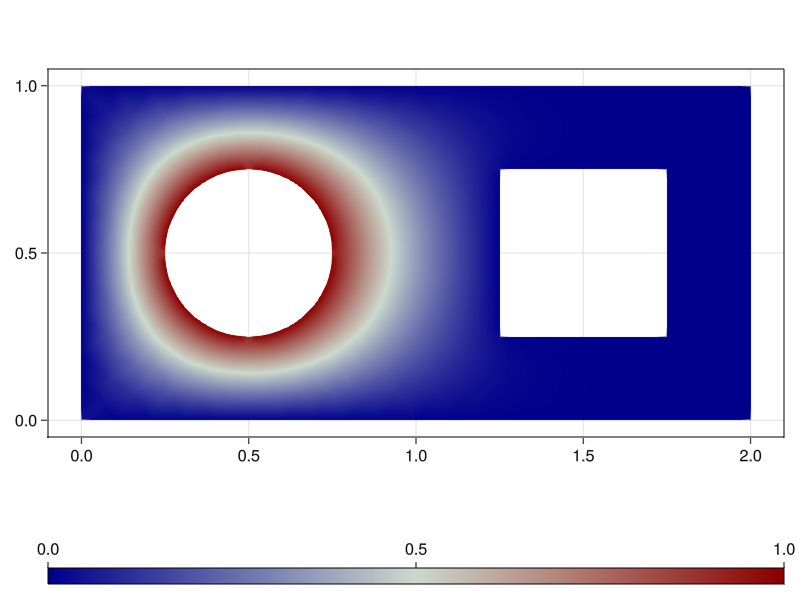

In [17]:
if plot_s 
    fig, ax, plt = plot(Ω, uh)
    ax.aspect = AxisAspect(2)
    Colorbar(fig[2,1], plt, vertical=false)
    fig
end

In [18]:
if capacity_cs
    writevtk(Ω,"images/solucion_cs_$res",cellfields=["uh_cs_$res" => uh])
    writevtk(Ω,"images/grad_cs_$res",cellfields=["grad_uh_cs_$res" => ∇(uh)])
elseif capacity_sc
    writevtk(Ω,"images/solucion_sc_$res",cellfields=["uh_sc_$res" => uh])
    writevtk(Ω,"images/grad_cs_$res",cellfields=["grad_uh_cs_$res" => ∇(uh)])
end

(["images/grad_cs_1.vtu"],)

Una vez obtenida la solución se pueden calcular algunas cantidades físicamente interesantes, por ejemplo la carga contenida en una región. Aquí calculamos la carga en la región exterior y en la interior. Note el cambio de signo para la interior ya que la normal siempre es toma saliente.

Recordemos que la carga se define como: 
\begin{equation}
Q_i = \int_{\partial \Omega_i} \sigma dS =  \frac{1}{4\pi}\int_{\partial \Omega_i} E \cdot \; dS
\end{equation}

Mientras que la  **matriz de capacidades** como: 

\begin{equation}
Q_i = C_{ij}V^j
\end{equation}

In [19]:
Γ_ext = BoundaryTriangulation(model,tags="ext")
dΓ_ext = Measure(Γ_ext,degree)
nb_ext = get_normal_vector(Γ_ext)
Q_ext = -sum(∫((nb_ext ⋅ ∇(uh)))*dΓ_ext)/4/π

0.5540677502478506

In [20]:
Γ_square = BoundaryTriangulation(model,tags="inner_square")
dΓ_square = Measure(Γ_square,degree)
nb_square = get_normal_vector(Γ_square)
Q_square = sum(∫((nb_square ⋅ ∇(uh)))*dΓ_square)/4/π

-0.05437553684473315

In [21]:
Γ_circle = BoundaryTriangulation(model,tags="inner_circle")
dΓ_circle = Measure(Γ_circle,degree)
nb_circle = get_normal_vector(Γ_circle)
Q_circle = sum(∫((nb_circle ⋅ ∇(uh)))*dΓ_circle)/4/π

0.5699503103742646

In [22]:
Q_ext - Q_circle - Q_square # esto debería dar cero si no hay fuentes (cargas).

0.038492976718319166

![Una imagen con visIt](images/visit0004.png)